# Koopman kernel models for TC Tracks

In this notebook we analyze the training results of the Koopman Nynstroem kernel model. Results are generated with the script `train_models/train_model_koopman_kernel.py` etc.

## Tropical cyclone dataset (1970 - 2020): RMSE versus kernel rank and context length

In this notebook we focus on the Nynstroem kernel and compare training results for various choices of model and data hyperparameter. We specifically have a look at the RMSE dependence on kernel rank and context length for the five most important cyclone basins 'EP', 'NA', 'SI', 'SP', 'WP'.

In [1]:
import os
from matplotlib import pyplot as plt
from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)
from klearn_tcyclone.climada.tc_tracks_tools import BASINS_SELECTION
from klearn_tcyclone.data_utils import load_model_results, load_model

The studied basins are:

In [2]:
BASINS_SELECTION

['EP', 'NA', 'SI', 'SP', 'WP']

Define model and data parameters and load results. The function `extend_by_default_flag_values`  sets  default values for all other parameters.

In [3]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"

# flag_params = {
#     "koopman_kernel_num_train_stops": 10,
#     "year_range": [1980, 2021],
#     "model": model_str,
#     "koopman_kernel_length_scale": 10.0,
#     "koopman_kernel_rank": 50,
#     "koopman_kernel_num_centers": 800,
# }
# flag_params = extend_by_default_flag_values(flag_params)

keys = ["context_length", "koopman_kernel_rank", "train_steps"]
context_lengths = [4, 8, 16, 32, 64]

results = {}
for koopman_kernel_rank in [50, 100, 150]:
    results[koopman_kernel_rank] = {}
    for context_length in context_lengths:
        flag_params = {
            "koopman_kernel_num_train_stops": 10,
            "year_range": [1980, 2021],
            "model": model_str,
            "koopman_kernel_length_scale": 10.0,
            "koopman_kernel_rank": koopman_kernel_rank,
            "koopman_kernel_num_centers": 800,
            "context_length": context_length,
            "koopman_kernel_reduced_rank": False,
        }
        flag_params = extend_by_default_flag_values(flag_params)
        results[koopman_kernel_rank][context_length] = {}
        for basin in BASINS_SELECTION:
            flag_params["basin"] = basin
            results[koopman_kernel_rank][context_length][basin] = load_model_results(flag_params, path_training_results, keys)

/home/ecjb/projects/koopman_learning_tropical_cyclone/klearn_tcyclone/data_utils.py:612: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load(results_file_name + f

Plotting the results: We compare three different values for the kernel rank (the three columns), and the individual basins (indicated by color). We fix the context length to 32.

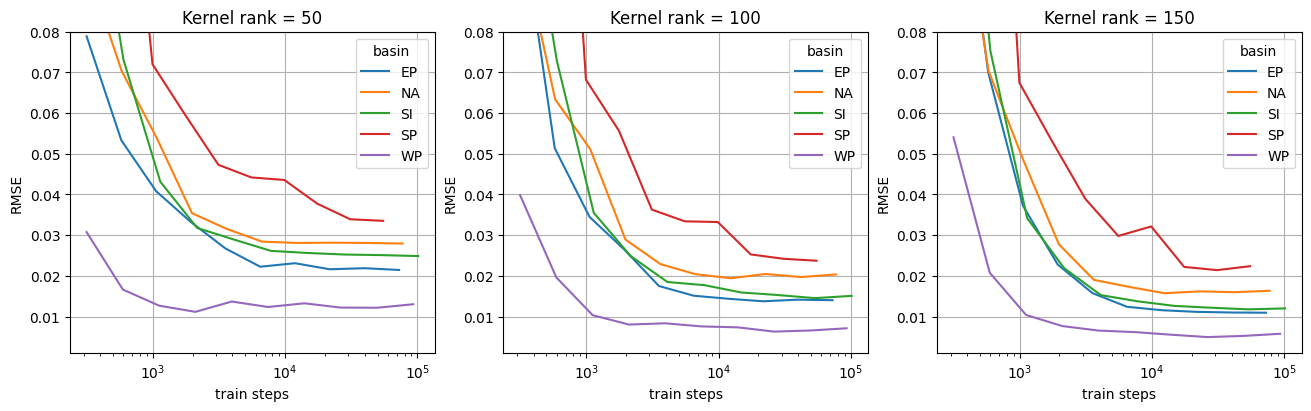

In [4]:
fig, ax = plt.subplots(1,3, layout="constrained")
fig.set_size_inches(13,4)

context_length = 32

for idx_kkrank, koopman_kernel_rank in enumerate([50, 100, 150]):

    for idx, basin in enumerate(results[koopman_kernel_rank][context_length].keys()):

        train_steps = list(results[koopman_kernel_rank][context_length][basin].keys())
        rmse = [results[koopman_kernel_rank][context_length][basin][step]["eval_rmse"] for step in train_steps]

        ax[idx_kkrank].plot(train_steps, rmse, color = f"C{idx}", label=basin)
    ax[idx_kkrank].set_xscale("log")
    # ax[idx_kkrank].set_yscale("log")
    ax[idx_kkrank].set_xlabel("train steps")
    ax[idx_kkrank].set_ylabel("RMSE")
    ax[idx_kkrank].set_ylim(0.001, 0.08)
    ax[idx_kkrank].grid()
    ax[idx_kkrank].legend(title="basin")
    ax[idx_kkrank].set_title(f"Kernel rank = {koopman_kernel_rank}")

The basin WP (West Pacific) has the smallest RMSE, however, this RMSE also does not depend strongly on the number of train steps. This indicates that the training dataset of the trajectories in WP is quite small, so these results are not very reliable. From the other basins, EP (East Pacific) exhibits overall the smallest RMSE.

In general, a larger kernel rank allows for a better convergence of the model, i.e. a smaller RMSE score.

In the next plot we also compare several values of the context length (rows in the plot below).

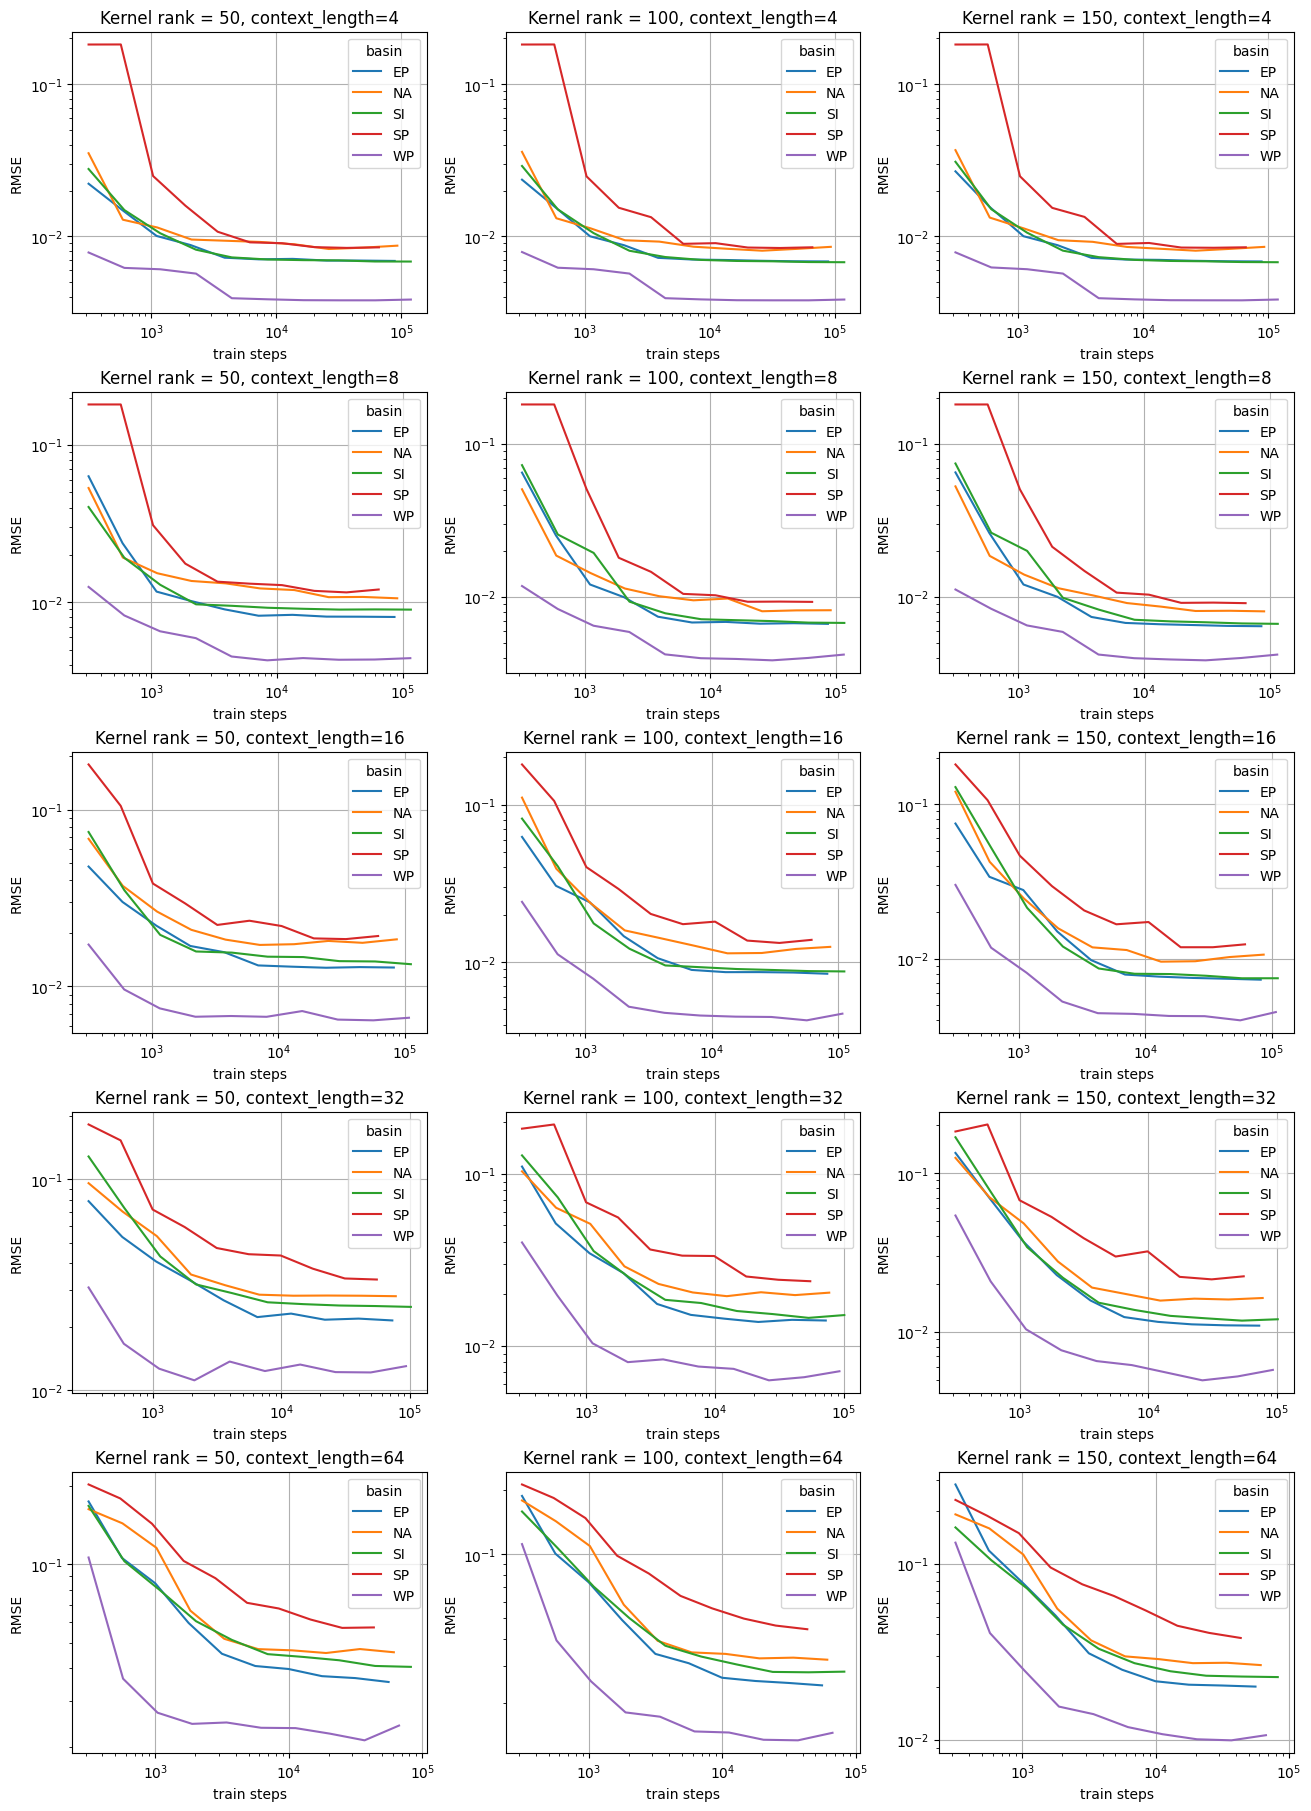

In [5]:
fig, ax = plt.subplots(len(context_lengths),3, layout="constrained")
fig.set_size_inches(13,18)


for idx_kctln, context_length in enumerate(context_lengths):
    for idx_kkrank, koopman_kernel_rank in enumerate([50, 100, 150]):

        for idx, basin in enumerate(results[koopman_kernel_rank][context_length].keys()):

            train_steps = list(results[koopman_kernel_rank][context_length][basin].keys())
            rmse = [results[koopman_kernel_rank][context_length][basin][step]["eval_rmse"] for step in train_steps]

            ax[idx_kctln, idx_kkrank].plot(train_steps, rmse, color = f"C{idx}", label=basin)
        ax[idx_kctln, idx_kkrank].set_xscale("log")
        ax[idx_kctln, idx_kkrank].set_yscale("log")
        ax[idx_kctln, idx_kkrank].set_xlabel("train steps")
        ax[idx_kctln, idx_kkrank].set_ylabel("RMSE")
        # ax[idx_kctln, idx_kkrank].set_ylim(0.010, 0.08)
        ax[idx_kctln, idx_kkrank].grid()
        ax[idx_kctln, idx_kkrank].legend(title="basin")
        ax[idx_kctln, idx_kkrank].set_title(f"Kernel rank = {koopman_kernel_rank}, context_length={context_length}")

## Trajectory prediction

In the second part of this notebook we use the best model to forecast trajectories and wind speed of the tropical cyclone track. We can use the CLIMADA plotting functions to generate nice plots of the predicted tracks.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
# from kooplearn.models import Kernel, NystroemKernel
from matplotlib import pyplot as plt
# from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    TCTracks_from_TensorContextDataset,
)
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
from klearn_tcyclone.models_utils import predict_time_series
# from klearn_tcyclone.performance_benchmark import timer

from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from itertools import product

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_SELECTION

# import pandas as pd
import os

# from klearn_tcyclone.data_utils import load_model_results
from klearn_tcyclone.data_utils import load_model, standardized_context_dataset_from_TCTracks

from klearn_tcyclone.climada.utils import get_TCTrack_dict

import cartopy.crs as ccrs
import climada.util.plot as u_plot

We focus on the NA (North Atlantic) basin in the following. From the model and scaler dictionaries we just need the corresponding entries.

In [2]:
basin = BASINS_SELECTION[1]
basins = [basin]
basin

'NA'

Here we import the full trained model, which we need below for forecasting the cyclone trajectories.

In [3]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"
context_lengths = [4, 8, 16, 32, 64]


models = {}
scalers = {}
for context_length in context_lengths:
    flag_params = {
        "koopman_kernel_num_train_stops": 10,
        "year_range": [1980, 2021],
        "model": model_str,
        "koopman_kernel_length_scale": 10.0,
        "koopman_kernel_rank": 50,
        "koopman_kernel_num_centers": 800,
        "koopman_kernel_reduced_rank": False,
        # "context_length": 16,
        "context_length": context_length,
    }
    flag_params = extend_by_default_flag_values(flag_params)
    models[context_length] = {}
    scalers[context_length] = {}
    for basin in basins:
        flag_params["basin"] = basin
        best_model_dict, _ = load_model(flag_params, path_training_results)
        models[context_length][basin] = best_model_dict["model"]
        scalers[context_length][basin] = best_model_dict["scaler"]

    # model = models[context_length][basin]
    # scaler = scalers[context_length][basin]

/home/ecjb/projects/koopman_learning_tropical_cyclone/klearn_tcyclone/data_utils.py:643: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_dict = torch.load(results_f

For forecasting, we have to import the tropical cyclone data of NA.

In [4]:
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

tc_tracks = get_TCTrack_dict(
    basins=[basin],
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)[basin]

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1, random_state=flag_params["seed"])

Device cuda
2025-01-05 10:52:35,928 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-05 11:01:04,917 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py (1545)

File "../../../packages/climada_python/climada/hazard/tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>

            time_step = pd.tseries.frequencies.to_offset(pd.Timedelta(hours=time_step_h)).freqstr
            ^

  @staticmethod


The context length sets the the lookback_len of the model to `context_len -1`. The model can make forecasts based on a given test context dataset. The context length of this dataset (on which the prediction should be made) can be larger than the lookback_len of the model. For each next-time-step-prediction, the model will always look at the last `model.lookback_len` entries (along axis 1) of the context dataset.

In [66]:
# context_length_test_data = 12
# context_length_test_data = 80
context_length_test_data = 120
print("Lookback length of one of the models:", models[16][basin].lookback_len)
print("Context length of the dataset on which the forecasting should be performed", context_length_test_data)

Lookback length of one of the models: 15
Context length of the dataset on which the forecasting should be performed 120


Note that we have to rescale the dataset with the pretrained and loaded scaler. This scaler is the same for all `context_length`, so we just choose one of them for rescaling below.

In [67]:
scaler = scalers[16][basin]

tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=context_length_test_data,
    # context_length=flag_params["context_length"],
    time_lag=flag_params["time_lag"],
    fit=False,
    periodic_shift=True,
    basin=basin,
)
tensor_context_test_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=feature_list,
    scaler=scaler,
    context_length=context_length_test_data,
    # context_length=flag_params["context_length"],
    time_lag=flag_params["time_lag"],
    fit=False,
    periodic_shift=True,
    basin=basin,
)

contexts = {
    "train": tensor_context_train_standardized,
    "test": tensor_context_test_standardized,
}


Shape of the test context window, axis 1 is the context window of the dataset. The last `model.lookback_len` entries along this axis are used for the forecast of the next time step.

In [68]:
print(contexts["test"].shape)

(4114, 120, 7)


Below we compare forecasting performance on a small random sub-dataset for the five considered context lengths.
We predict `n_steps = 40` steps into the future. The function `predict_time_series` takes the forecasting model and the context dataset as input and makes multi-time-step forecasts based on a sliding window. I.e. it advances the trajectory one time step at a time and always predicts the next time step based on the last `model.lookback_len` entries of the resulting partially predicted context dataset.

In [69]:
n_steps_future = 40

idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]

predicted_context = {}
for context_length in context_lengths:
    predicted_context[context_length] = predict_time_series(models[context_length][basin], test_context, n_steps=n_steps_future, context_length=models[context_length][basin].lookback_len + 1)

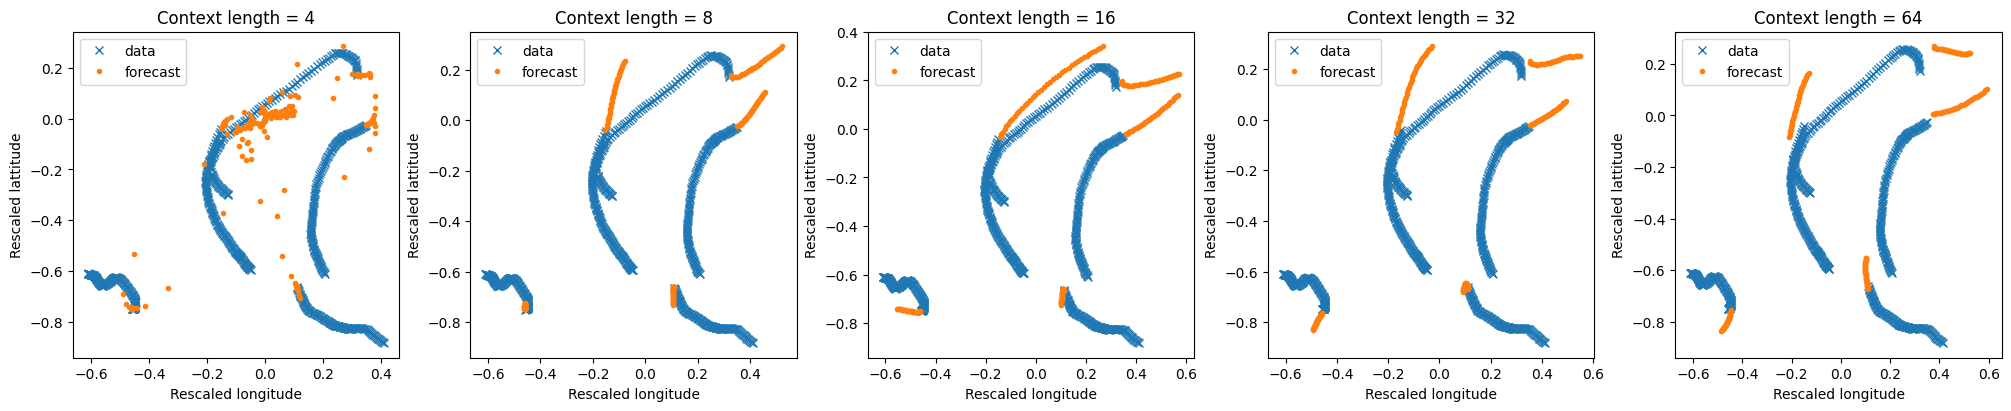

In [70]:
fig, ax = plt.subplots(1, len(context_lengths), layout="constrained")
fig.set_size_inches(20,4)

for idx_cl, context_length in enumerate(context_lengths):

    data = test_context.data.reshape(-1, 7)
    forecast = predicted_context[context_length].reshape(-1, 7)
    
    ax[idx_cl].plot(data[:, 0], data[:, 1], "x", color="C0", label="data")
    ax[idx_cl].plot(forecast[:, 0], forecast[:, 1], ".", color="C1", label="forecast")

    ax[idx_cl].set_title(f"Context length = {context_length}")
    ax[idx_cl].set_xlabel("Rescaled longitude")
    ax[idx_cl].set_ylabel("Rescaled lattitude")

    ax[idx_cl].legend()

We see that the context length has a huge influence on the consistent prediction of several time steps. Only using one-step prediction RMSE thus might be not a good quantifier to assess the long-time forecasting performance of the model. In the plots above we see that a short context window of 4 gives very poor results. The best context window size seems to be 16. For context window 8, the prediction looks good, however one notices that the 40 predicted time steps are very clustered, such as the model predicts a reduction of velocity of the cyclone the stronger the longer the prediction window. For larger context windows of 32 and 64 we see again a degregation of the forecasting performance.

#### Forecast in geographic coordinates

In the next step we want to visualize the tropical cyclone tracks and the predictions on the actual geographic map, not in the rescaled coordinates. For this we have to scale and translate data and forecast back to the original coordinate system. For this we require the inverse_transform of the scaler.

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

We fix the context length to 16, the best choice based on the above plots.

In [71]:
context_length = 16

As the context window is pretty large, we take out only every third entry and build a TCTRacks object from this. This TCTracks object can be plotted in geographic coordinates by using a slight modification of CLIMADAs plotting functions (implemented in the custom TCTracks class in `klearn_tcyclone/climada/tc_tracks`).

In [75]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context[context_length])
test_context_tc_tracks = TCTracks_from_TensorContextDataset(test_context_scaled[:,::3], feature_list=feature_list)
predicted_context_tc_tracks = TCTracks_from_TensorContextDataset(predicted_context_scaled[:,::3], feature_list=feature_list)

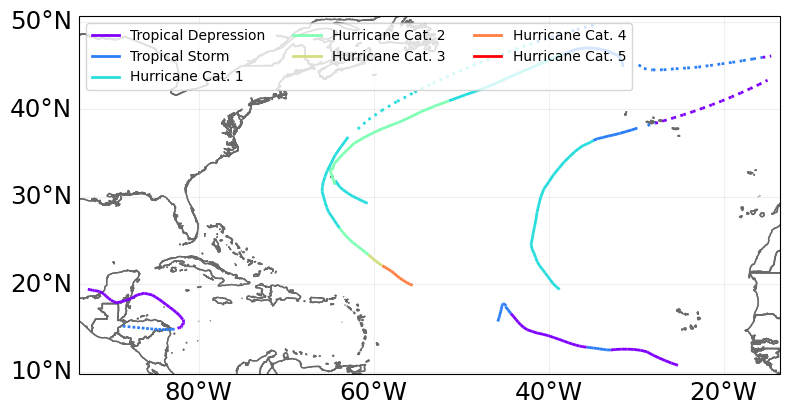

In [74]:
# figsize=(9, 13)
figsize=(8, 8)
adapt_fontsize=True
# max_lat = 75
# min_lat = 5

extent_test = test_context_tc_tracks.get_extent(deg_buffer=1)
extent_prediction = predicted_context_tc_tracks.get_extent(deg_buffer=1)
extent_test = test_context_tc_tracks.get_extent(deg_buffer=1)
extent_prediction = predicted_context_tc_tracks.get_extent(deg_buffer=1)
min_lon = np.min([extent_test[0], extent_prediction[0]])
max_lon = np.max([extent_test[1], extent_prediction[1]])
min_lat = np.min([extent_test[2], extent_prediction[2]])
max_lat = np.max([extent_test[3], extent_prediction[3]])

mid_lon = 0.5 * (min_lon + max_lon)
proj = ccrs.PlateCarree(central_longitude=mid_lon)

fig, ax, _ = u_plot.make_map(
    num_sub=(1,1),
    proj=proj, figsize=figsize, adapt_fontsize=adapt_fontsize
)


extent = (min_lon, max_lon, min_lat, max_lat)
_ = test_context_tc_tracks.plot(
    axis=ax,
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle="solid",
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)

_ = predicted_context_tc_tracks.plot(
    axis=ax,
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle="dotted",
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)


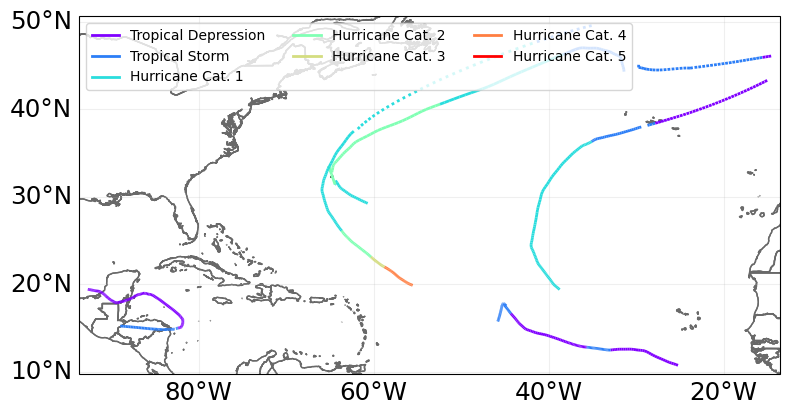

In [77]:
# figsize=(9, 13)
figsize=(8, 8)
adapt_fontsize=True
# max_lat = 75
# min_lat = 5

extent_test = test_context_tc_tracks.get_extent(deg_buffer=1)
extent_prediction = predicted_context_tc_tracks.get_extent(deg_buffer=1)
extent_test = test_context_tc_tracks.get_extent(deg_buffer=1)
extent_prediction = predicted_context_tc_tracks.get_extent(deg_buffer=1)
min_lon = np.min([extent_test[0], extent_prediction[0]])
max_lon = np.max([extent_test[1], extent_prediction[1]])
min_lat = np.min([extent_test[2], extent_prediction[2]])
max_lat = np.max([extent_test[3], extent_prediction[3]])

mid_lon = 0.5 * (min_lon + max_lon)
proj = ccrs.PlateCarree(central_longitude=mid_lon)

fig, ax, _ = u_plot.make_map(
    num_sub=(1,1),
    proj=proj, figsize=figsize, adapt_fontsize=adapt_fontsize
)


extent = (min_lon, max_lon, min_lat, max_lat)
_ = test_context_tc_tracks.plot(
    axis=ax,
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle="solid",
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)

_ = predicted_context_tc_tracks.plot(
    axis=ax,
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle="dotted",
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)


This looks reasonably. However, the predictions are still improvable. For example we notice an off-set for the predicted trajectory in relation to the context trajectory.

In the next step, we take a closer look at the context length of the training data and study its influence on the model performance.

#### NOTE:

Checkout from kooplearn._src.operator_regression.dual import predict

This function can predict for several time steps but only outputs the last one. Predicting a given context for several timesteps leads probably to something different than predicting one time step ahead, building the new context by shifting to this, and compute the next time step prediction and so on. Could be interesting to compare these two things in terms of runtime and accuracy. Predicting several time steps for given context without shift should be much faster, since only matrix multiplication needs to be applied iteratively. For this predict() needs to be slightly modified to also return intermediate results.